In [38]:
import os
import math
import random
import time 

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sys
sys.path.append('../')

from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [6]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

## SSD 300 Model

The SSD 300 network takes 300x300 image inputs. In order to feed any image, the latter is resize to this input shape (i.e.`Resize.WARP_RESIZE`). Note that even though it may change the ratio width / height, the SSD model performs well on resized images (and it is the default behaviour in the original Caffe implementation).

SSD anchors correspond to the default bounding boxes encoded in the network. The SSD net output provides offset on the coordinates and dimensions of these anchors.

In [7]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ../checkpoints/ssd_300_vgg.ckpt


## Post-processing pipeline

The SSD outputs need to be post-processed to provide proper detections. Namely, we follow these common steps:

* Select boxes above a classification threshold;
* Clip boxes to the image shape;
* Apply the Non-Maximum-Selection algorithm: fuse together boxes whose Jaccard score > threshold;
* If necessary, resize bounding boxes to original image shape.

In [8]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

## Draw Bounding Boxes

We draw boxes on each object found and additionally mark the name of the class from the pascal_classes dictionary

In [9]:
pascal_classes = {0:"background",1:"aeroplane",2:"bicycle",3:"bird",4:"boat",5:"bottle",6:"bus",7:"car",8:"cat",9:"chair",10:"cow",11:"diningtable",12:"dog",13:"horse",14:"motorbike",15:"person",16:"pottedplant",17:"sheep",18:"sofa",19:"train",20:"tvmonitor"}

In [42]:
colors = dict()
def plt_bboxes(img, classes, scores, bboxes, figsize=(17.78,10), linewidth=1.5):
    """Visualize bounding boxes. Largely inspired by SSD-MXNET!
    """
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    plt.imshow(img)
    height = img.shape[0]
    width = img.shape[1]
    print ("original height width", height, width)
    for i in range(classes.shape[0]):
        cls_id = int(classes[i])
        if cls_id >= 0:
            score = scores[i]
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            ymin = int(bboxes[i, 0] * height)
            xmin = int(bboxes[i, 1] * width)
            ymax = int(bboxes[i, 2] * height)
            xmax = int(bboxes[i, 3] * width)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=linewidth)
            plt.gca().add_patch(rect)
            class_name = pascal_classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                           '{:s} | {:.3f}'.format(class_name, score),
                           bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                           fontsize=12, color='white')
            print ("Frame has class", class_name)
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    print("Processed data")
    return data

## Custom Implementation for running SSD on Video Frames

Takes a path of a video, and a unique identifier (name) for the video. Processes each frame, and saves the output video based on the id given

In [45]:
def run_ssd_on_video(video_path, video_name):
    start_time = time.time()
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    out_path = "out_" + video_name + "_SSD" + ".avi"
    out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (1280,720)) #width, height format
    i = 0
    people_frames = []
    while(cap.isOpened()):
        has_frame, frame = cap.read()
        if not has_frame: 
            break
        # Custom code here 
        i += 1
        print ("Processing frame #", i)
        rclasses, rscores, rbboxes =  process_image(frame)
        print (rclasses)
        if (15 in rclasses):
            people_frames.append(i)
        out.write(plt_bboxes(frame, rclasses, rscores, rbboxes))  
    print("Finished reading video")
    print ("Wrote video to ", out_path)
    print ("Frames with person", people_frames)
    cap.release()
    out.release()
    time_taken = time.time() - start_time
    print("Time taken = ", time_taken)
    print("FPS = ", str(float(i/time_taken)))

## Testing 

original height width 720 1280


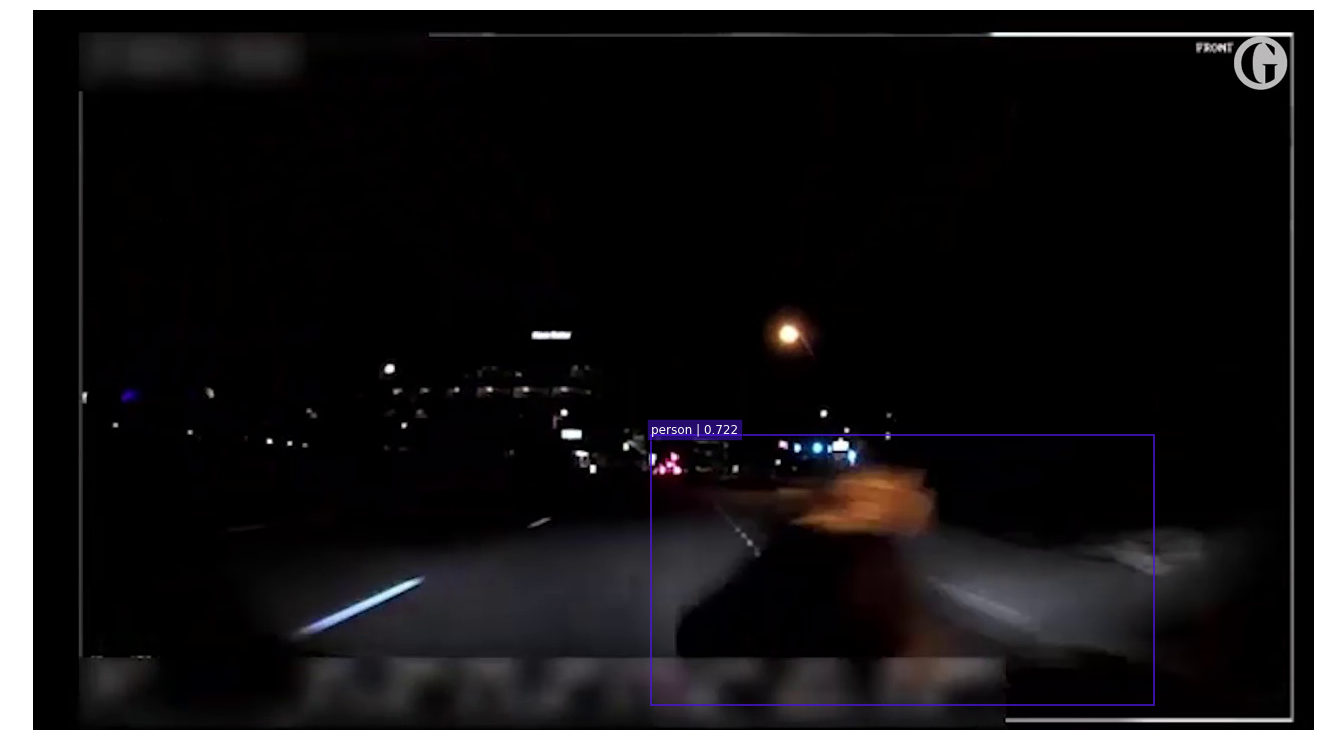

Processed data


In [20]:
# Test on some demo image and visualize output.
path = '../../Frames/'
image_names = sorted(os.listdir(path))

img = mpimg.imread(path + image_names[-1])
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
x = plt_bboxes(img, rclasses, rscores, rbboxes)

In [43]:
run_ssd_on_video("../../uber_trimmed.mp4", "uber_trimmed_new_test")

Processing frame # 1
[]
original height width 720 1280
Processed data
Processing frame # 2
[]
original height width 720 1280
Processed data
Processing frame # 3
[]
original height width 720 1280
Processed data
Processing frame # 4
[]
original height width 720 1280
Processed data
Processing frame # 5
[7]
original height width 720 1280
Frame has class car
Processed data
Processing frame # 6
[]
original height width 720 1280
Processed data
Processing frame # 7
[]
original height width 720 1280
Processed data
Processing frame # 8
[]
original height width 720 1280
Processed data
Processing frame # 9
[]
original height width 720 1280
Processed data
Processing frame # 10
[7]
original height width 720 1280
Frame has class car
Processed data
Processing frame # 11
[7]
original height width 720 1280
Frame has class car
Processed data
Processing frame # 12
[7]
original height width 720 1280
Frame has class car
Processed data
Processing frame # 13
[]
original height width 720 1280
Processed data
Pr

[]
original height width 720 1280
Processed data
Processing frame # 107
[]
original height width 720 1280
Processed data
Processing frame # 108
[]
original height width 720 1280
Processed data
Processing frame # 109
[]
original height width 720 1280
Processed data
Processing frame # 110
[]
original height width 720 1280
Processed data
Processing frame # 111
[]
original height width 720 1280
Processed data
Processing frame # 112
[]
original height width 720 1280
Processed data
Processing frame # 113
[]
original height width 720 1280
Processed data
Processing frame # 114
[]
original height width 720 1280
Processed data
Processing frame # 115
[]
original height width 720 1280
Processed data
Processing frame # 116
[]
original height width 720 1280
Processed data
Processing frame # 117
[]
original height width 720 1280
Processed data
Processing frame # 118
[]
original height width 720 1280
Processed data
Processing frame # 119
[]
original height width 720 1280
Processed data
Processing fram

original height width 720 1280
Frame has class person


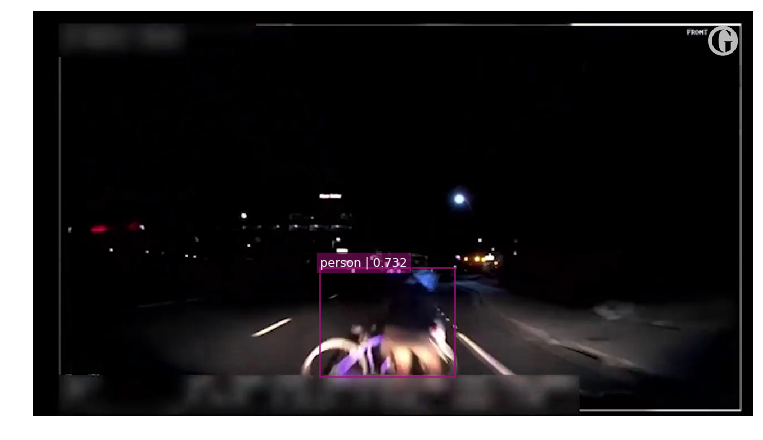

Processed data


In [35]:
img = cv2.imread("../../Frames/frame89.jpg")
rclasses, rscores, rbboxes =  process_image(img)
x = plt_bboxes(img, rclasses, rscores, rbboxes, (10,10), 1.5)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)

In [74]:
run_ssd_on_video("Crashes/crash1.mp4", "crash1")
run_ssd_on_video("Crashes/crash2.mp4", "crash2")
run_ssd_on_video("Crashes/crash3.mp4", "crash3")
run_ssd_on_video("Crashes/crash4.mp4", "crash4")
run_ssd_on_video("Crashes/crash5.mp4", "crash5")
run_ssd_on_video("Crashes/crash6.mp4", "crash6")
run_ssd_on_video("Crashes/crash7.mp4", "crash7")
run_ssd_on_video("Crashes/crash8.mp4", "crash8")
run_ssd_on_video("Crashes/crash9.mp4", "crash9")
run_ssd_on_video("Crashes/crash10.mp4", "crash10")
run_ssd_on_video("Crashes/crash11.mp4", "crash11")

Processing frame # 1
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 2
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 3
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 4
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 5
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 6
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 7
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 8
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 9
original height width 720 1280
This frame has class

original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 72
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 73
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 74
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 75
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 76
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 77
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 78
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 79
original height width 720 1280
This frame has class
Processed da

original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 143
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 144
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 145
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 146
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 147
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 148
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 149
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 150
original height width 720 1280
This frame has class
Proc

original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 213
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 214
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 215
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 216
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 217
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 218
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 219
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 220
original height width 720 1280
This frame has class
Proc

Processed data with shape,  (720, 1280, 3)
Processing frame # 283
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 284
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 285
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 286
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 287
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 288
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 289
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 290
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing fr

original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 64
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 65
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 66
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 67
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 68
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 69
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 70
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 71
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 72
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 7

original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 137
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 138
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 139
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 140
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 141
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 142
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 143
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 144
original height width 720 1280
This frame has class
Proc

original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 207
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 208
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 209
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 210
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 211
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 212
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 213
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 214
original height width 720 1280
This frame has class
Proc

Processing frame # 14
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 15
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 16
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 17
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 18
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 19
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 20
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 21
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 22
original height width 720 1280
This frame 

Processed data with shape,  (720, 1280, 3)
Processing frame # 86
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 87
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 88
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 89
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 90
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 91
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 92
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 93
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 94

original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 35
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 36
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 37
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 38
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 39
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 40
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 41
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 42
original height width 720 1280
This frame has class
Processed da

original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 20
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 21
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 22
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 23
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 24
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 25
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 26
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 27
original height width 720 1280
This frame has class
Processed da

Processed data with shape,  (720, 1280, 3)
Processing frame # 91
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Finished reading video
Wrote video to  out_crash5_SSD.avi
Frames with person [73]
Processing frame # 1
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 2
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 3
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 4
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 5
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 6
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 7
original height width 720 1280
This frame

Processed data with shape,  (720, 1280, 3)
Processing frame # 70
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 71
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 72
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 73
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 74
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 75
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 76
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 77
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 78

Processed data with shape,  (720, 1280, 3)
Processing frame # 15
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 16
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 17
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 18
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 19
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 20
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 21
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 22
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 23

original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 86
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 87
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 88
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 89
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 90
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 91
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 92
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 93
original height width 720 1280
This frame has class
Processed da

original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 55
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 56
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 57
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 58
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 59
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 60
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 61
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 62
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 63
original height width 720 1280
Processed data with shape,  (720, 1280, 3)

Processed data with shape,  (720, 1280, 3)
Processing frame # 131
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 132
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 133
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 134
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 135
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 136
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 137
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 138
original height width 720 1280
Processed data with shape,  (720, 1280, 3)
Processing frame # 139
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 140
original height wid

original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 61
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 62
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 63
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 64
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 65
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 66
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 67
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 68
original height width 720 1280
This frame has class
Processed da

original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 132
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 133
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 134
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 135
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 136
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 137
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 138
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 139
original height width 720 1280
This frame has class
Proc

original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 23
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 24
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 25
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 26
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 27
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 28
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 29
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 30
original height width 720 1280
This frame has class
Processed da

Processed data with shape,  (720, 1280, 3)
Processing frame # 93
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 94
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 95
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 96
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 97
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 98
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 99
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 100
original height width 720 1280
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 1

original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 14
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 15
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 16
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 17
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 18
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 19
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 20
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 21
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 22
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 23
original height width 360 640
Processed data with 

original height width 360 640
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 90
original height width 360 640
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 91
original height width 360 640
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 92
original height width 360 640
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 93
original height width 360 640
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 94
original height width 360 640
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 95
original height width 360 640
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 96
original height width 360 640
This frame has class
Processed data with shape,  (720, 1280, 3)
Processing frame # 97
original height width 360 640
This frame has class
Processed data with s

original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 170
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 171
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 172
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 173
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 174
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 175
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 176
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 177
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 178
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 179
original height width 360 640
Processed 

original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 256
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 257
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 258
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 259
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 260
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 261
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 262
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 263
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 264
original height width 360 640
Processed data with shape,  (720, 1280, 3)
Processing frame # 265
original height width 360 640
Processed 